In [74]:
# Time-dependent evolution for the distribution function using the BGK (relaxation) collision operator

# using necessary packages
using LaTeXStrings, Markdown, DataFrames, Queryverse, Plots, Printf
 
df = load("coronal_loop_data.csv", spacedelim=true, header_exists=true) |> DataFrame

,s,ds,n,T
,Float64,Float64,Float64,Float64
1,5.0e6,1.0e7,1.86965e13,20000.0
2,1.5e7,1.0e7,1.67889e13,20000.0
3,2.5e7,1.0e7,1.50764e13,20000.0
4,3.5e7,1.0e7,1.35391e13,20000.0
5,4.5e7,1.0e7,1.21591e13,20000.0
6,5.5e7,1.0e7,1.09201e13,20000.0
7,6.5e7,1.0e7,9.80791e12,20000.0
8,7.5e7,1.0e7,8.80938e12,20000.0
9,8.5e7,1.0e7,7.91291e12,20000.0


In [75]:
println("BGK Equation")
println("Consider a single species with a constant collisional frequency")
L"""\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
    = \
    v_{ss}(F_s - f_s) \ """

#= Reference: 
Eq. (26)
Bradshaw, S.J., Raymond, J. Collisional and Radiative Processes in Optically Thin Plasmas. Space Sci Rev 178, 271–306 (2013). 
https://doi.org/10.1007/s11214-013-9970-0
=#

BGK Equation
Consider a single species with a constant collisional frequency


L"$\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
= \
v_{ss}(F_s - f_s) \ $"

In [76]:
m_e = 9.11E-28 # electron mass [g]
k = 1.38E-16 # boltzmann constant [erg*K^-1]
v = range(1e10, -1e10, step=-1e8) # velocity [cm/s]

T_M = 1e6 # temperature of Maxwellian [K]
T_N = 2.5e7 # temperature of chosen initial distribution [K]

function Maxwellian(v_Max, T_Max)
    ```Maxwellian distribution function for particles moving in only one direction```
    normal = (m_e/(2*pi*k*T_Max))^1.5
    exp_term = exp(-((m_e).*v_Max.*v_Max)/(3*k*T_Max))
    return exp_term
end


Maxwellian (generic function with 1 method)

In [77]:
# Initially comparing chosen distribution f_s to Maxwellian F_s
plot(v, Maxwellian.(v, T_M), label= L"F_s" * " (Maxwellian)")
plot!(v, Maxwellian.(v, T_N), linestyle = :dash, label= L"f_s")
xlabel!("velocity (cm/s)")
ylabel!("probability density")
savefig("BGK_initial.png")

┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Julia\Simple-BGK-Model\Simple_BGK_Explicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Julia\Simple-BGK-Model\Simple_BGK_Implicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Julia\Simple-BGK-Model\Simple_BGK_Time_Discretization_Both.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Acer\\Downloads\\Julia\\Simple-BGK-Model\\Simple_BGK_Time_Discretization_Both.gif")
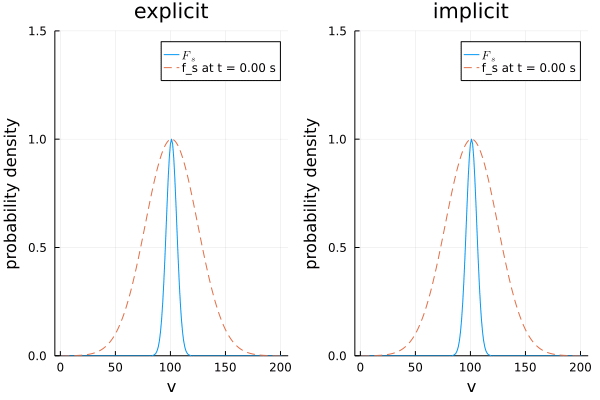

In [78]:
# Temporal discretization 

v_col = 1

dt = 10^(-5) # timestep
t = range(0, 3.0, step=dt)

f_s0 = Maxwellian.(v, T_N)
f_s_exp = [f_s0] # explicit method
f_s_imp = [f_s0] # implicit method
F_s = Maxwellian.(v, T_M)

for it in 1:length(t)-1
    push!(f_s_exp, dt*v_col*(F_s - f_s_exp[it]) + f_s_exp[it])
    push!(f_s_imp, (f_s_imp[it] + v_col*F_s*dt)/(1 + v_col*dt))
end

frame_rate = 15 # frames per second for gifs

anim_exp = @animate for i in 1:1000:length(t)
           plot(F_s; label=L"F_s")
           plot!(f_s_exp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("v")
           ylabel!("probability density")
           title!("Simple BGK Model (explicit method)")
       end;

gif(anim_exp, "Simple_BGK_Explicit.gif"; fps=frame_rate)

anim_imp = @animate for i in 1:1000:length(t)
           plot(F_s; label=L"F_s")
           plot!(f_s_imp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("v")
           ylabel!("probability density")
           title!("Simple BGK Model (implicit method)")
       end;

gif(anim_imp, "Simple_BGK_Implicit.gif"; fps=frame_rate)

anim_both = @animate for i in 1:1000:length(t)
           a = plot(F_s; label=L"F_s")
           a = plot!(f_s_exp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           a = title!("explicit")
           b = plot(F_s; label=L"F_s")
           b = plot!(f_s_imp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           b = title!("implicit")
           plot(a, b, layout = (1, 2), legend = true)
           xlabel!("v")
           ylabel!("probability density")
            
       end;

gif(anim_both, "Simple_BGK_Time_Discretization_Both.gif"; fps=frame_rate)

In [40]:
# Spatial discretization 

#=

v_col = 1 # collisional frequency [s^-1]
v = filter(!=(0), range(1e10, -1e10, step=-1e8)) # skip over zero velocity

f_s = [Maxwellian.(v, df.T[1])]
F_s = Maxwellian.(v, T_M)

for is in 1:length(df.s)
    push!(f_s, f_s[is] - (v_col./v).*(df.ds[is]).*(f_s[is] - F_s))
end

#plot(v, f_s[300])

anim = @animate for i in 1:length(df.s)
           plot(v, f_s[i]; label=@sprintf("f_s at s = %.2f cm", df.s[i]))
           xlabel!("velocity (cm/s)")
           ylabel!("probability density")
           title!("Maxwellian")
       end;

gif(anim, "Simple_BGK_Spatial_Discretization.gif"; fps=10)

=#

600


LoadError: InterruptException: